This notebook takes brain voxels and maps them to CLIP-space.

In [1]:
# # convert this notebook to .py such that you can then run it via slurm with "sbatch *.slurm"
# from subprocess import call
# command = "jupyter nbconvert Brain_to_CLIP.ipynb --to python"
# call(command,shell=True)

# Import packages & functions

In [2]:
import os
import sys
import json
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from info_nce import InfoNCE
from dalle2_pytorch import DiffusionPriorNetwork
import kornia
from kornia.augmentation.container import AugmentationSequential
import umap

import torch.distributed as dist
from accelerate import Accelerator

# uses tf32 data type which is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# Multi-GPU config #
accelerator = Accelerator()
print = accelerator.print # only print if local_rank=0

device = accelerator.device
print("device:",device)

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices

print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
if num_devices<=1 and world_size<=1:
    distributed=False
else:
    distributed=True
print("distributed =",distributed,"num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)

# custom models and functions #
import utils
from utils import torch_to_matplotlib, torch_to_Image
from models import BrainNetwork, BrainDiffusionPrior
# from model3d import SimpleVoxel3dConvEncoder

device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1


# Configurations

In [8]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    jupyter_args=[]
    jupyter_args.append("--model_name=flatmsee")
    jupyter_args.append("--modality=image")
    jupyter_args.append("--clip_variant=ViT-L/14")
    jupyter_args.append("--batch_size=300")
    jupyter_args.append("--with_mse")
    jupyter_args.append("--versatile")
    jupyter_args.append("--n_samples_save=1")
    jupyter_args.append("--mse_amount=.1")
    jupyter_args.append("--max_lr=3e-4")
    jupyter_args.append("--mixup_pct=.3")
    jupyter_args.append("--num_epochs=400")
    # jupyter_args.append("--wandb_log")
    jupyter_args.append("--ckpt_interval=5")
    jupyter_args.append("--resume_from_ckpt")
    print(jupyter_args)
    
    from IPython.display import clear_output
    
    %load_ext autoreload
    %autoreload 2

['--model_name=flatmsee', '--modality=image', '--clip_variant=ViT-L/14', '--batch_size=300', '--with_mse', '--versatile', '--n_samples_save=1', '--mse_amount=.1', '--max_lr=3e-4', '--mixup_pct=.3', '--num_epochs=400', '--ckpt_interval=5', '--resume_from_ckpt']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging",
)
parser.add_argument(
    "--modality", type=str, default="image", choices=["image", "text"],
    help="image or text",
)
parser.add_argument(
    "--batch_size", type=int, default=300,
    help="Our maximum for A100 was 300 for 1dim voxels and 128 for 3dim voxels",
)
parser.add_argument(
    "--clip_variant",type=str,default="ViT-L/14",choices=["RN50", "ViT-L/14", "ViT-B/32", "ViT-H-14", "RN50x64"],
    help='clip / openclip variant',
)
parser.add_argument(
    "--outdir",type=str,default=None,
    help="output directory for logs and checkpoints",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.5,
    help="proportion of way through training when to switch from InfoNCE to soft_clip_loss",
)
parser.add_argument(
    "--voxel_dims",type=int,default=1,choices=[1, 3],
    help="1 for flattened input, 3 for 3d input",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation (only used for modality=image)",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','fixed'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--save_at_end",action=argparse.BooleanOptionalAction,default=False,
    help="if False, will save best.ckpt whenever epoch shows best validation score",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--with_mse",action=argparse.BooleanOptionalAction,default=False,
    help="Add mse loss to the other losses",
)
parser.add_argument(
    "--mse_mult",type=int,default=1,
    help="Multiplier for mse loss",
)
parser.add_argument(
    "--versatile",action=argparse.BooleanOptionalAction,default=False,
    help="Map to 257x768 versatile diffusion CLIP space, not including class token",
)
parser.add_argument(
    "--mse_amount",type=float,default=.5,
    help="What percentage of to weight mse vs. soft_clip loss",
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)
parser.add_argument(
    "--n_samples_save",type=int,default=0,
    help="Number of reconstructions for monitoring progress, 0 will speed up training",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [5]:
if outdir is None:
    outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir):
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    train_augs = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.5),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        data_keys=["input"],
    )
else:
    train_augs = None
if modality=='text':
    annots = np.load("/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_annots_curated.npy")
    import logging
    logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
    from transformers import CLIPTextModelWithProjection, CLIPTokenizer
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    text_encoder = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to(device)
    text_encoder.eval()
    text_encoder.requires_grad_(False)

# Prep models and data loaders

In [6]:
# need non-deterministic CuDNN for conv3D to work
utils.seed_everything(seed, cudnn_deterministic=False)

print('Pulling NSD webdataset data...')

train_url = "{/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/train/train_subj01_{0..17}.tar,/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/val/val_subj01_0.tar}"
val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/test/test_subj01_{0..1}.tar"
meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset_avg_split/metadata_subj01.json"
num_train = 8559 + 300
num_val = 982

# which to use for the voxels
if voxel_dims == 1:
    voxels_key = 'nsdgeneral.npy'
elif voxel_dims == 3:
    voxels_key = 'wholebrain_3d.npy'
else:
    raise Exception(f"voxel_dims must be 1 or 3, not {voxel_dims}")

print('Prepping train and validation dataloaders...')
train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=batch_size,
    cache_dir="/tmp/wds-cache",
    seed=seed,
    voxels_key=voxels_key,
    to_tuple=["voxels", "images", "coco"],
    local_rank=local_rank,
)

if voxel_dims == 3:
    import nibabel as nib
    noise_ceils_path = '/fsx/proj-medarc/fmri/natural-scenes-dataset/temp_s3/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz'
    noise_ceils = nib.load(noise_ceils_path).get_fdata()
    x_inc,y_inc,z_inc = np.where(noise_ceils > .5) # voxel.shape torch.Size([300, 3, 68, 64, 47])

Note: not using cudnn.deterministic
Pulling NSD webdataset data...
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 300
batch_size 300
num_workers 1
num_batches 29
num_worker_batches 29
cache_dir None

num_val 982
val_batch_size 300
val_num_workers 1


In [7]:
print('Creating Clipper...')
    
# Don't L2 norm the extracted CLIP embeddings since we want the prior 
# to learn un-normed embeddings for usage with the SD image variation pipeline.
from models import Clipper
if versatile:
    print("Using versatile CLIP space")
    clip_extractor = Clipper(clip_variant, device=device, hidden_state=True, train_transforms=train_augs)
    out_dim = 257 * 768
elif modality=='image':
    clip_extractor = Clipper(clip_variant, device=device, hidden_state=True, train_transforms=train_augs)
    out_dim = 768
else:
    annots = np.load("/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_annots_curated.npy")
    out_dim = 77 * 768
print("out_dim:",out_dim)

print('Creating voxel2clip...')

if voxel_dims == 1: # 1D data
    voxel2clip_kwargs = dict(out_dim=out_dim)
    voxel2clip = BrainNetwork(**voxel2clip_kwargs)
elif voxel_dims == 3: # 3D data
    if modality=='text':
        voxel2clip_kwargs = dict(
            out_dim=77*outdim,
            dims=voxel.shape[2:],
            channels=[64, 128, 256, 128],
            strides=[1, 2, 3, 3],
            padding=[1, 1, 1, 1],
            dilation=[1, 1, 1, 1],
            kernel=[3, 3, 3, 3],
        )
    else:
        voxel2clip_kwargs = dict(
            out_dim=out_dim,
            dims=voxel.shape[2:],
            channels=[64, 128, 256, 128],
            strides=[1, 2, 3, 3],
            padding=[1, 1, 1, 1],
            dilation=[1, 1, 1, 1],
            kernel=[3, 3, 3, 3],
        )
    voxel2clip = SimpleVoxel3dConvEncoder(**voxel2clip_kwargs)  

# learnable logit scaling
voxel2clip.temp = nn.Parameter(torch.tensor(.006))
    
print("params of voxel2clip:")
if local_rank==0:
    utils.count_params(voxel2clip)

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in voxel2clip.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in voxel2clip.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=3e-4) # lr doesnt get used if lr_scheduler_type='cycle'

if lr_scheduler_type == 'fixed':
    lr_scheduler = None
elif lr_scheduler_type == 'cycle':
    global_batch_size = batch_size * num_devices
    total_steps=num_epochs*(num_train//global_batch_size)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
if n_samples_save > 0:
    if local_rank == 0: print('Creating versatile diffusion reconstruction pipeline...')
    from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler, Transformer2DModel
    from diffusers.models import DualTransformer2DModel
    from diffusers.pipelines.versatile_diffusion.modeling_text_unet import UNetFlatConditionModel

    with torch.no_grad():
        sd_cache_dir = '/fsx/proj-medarc/fmri/cache/models--shi-labs--versatile-diffusion/snapshots/2926f8e11ea526b562cd592b099fcf9c2985d0b7'
        if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
            from diffusers import VersatileDiffusionPipeline
            print("Downloading from huggingface...")
            sd_pipe = VersatileDiffusionPipeline.from_pretrained("shi-labs/versatile-diffusion")
            sd_cache_dir = "shi-labs/versatile-diffusion"
        unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="image_unet").to(device)
        unet.eval() # dont want to train model
        unet.requires_grad_(False) # dont need to calculate gradients

        vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae").to(device)
        vae.eval()
        vae.requires_grad_(False)

        text_unet = UNetFlatConditionModel.from_pretrained(sd_cache_dir,subfolder="text_unet").to(device)
        text_unet.eval() # dont want to train model
        text_unet.requires_grad_(False) # dont need to calculate gradients

        noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
        noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)
        num_inference_steps = 20

        # convert to dual attention         
        for name, module in unet.named_modules():
            if isinstance(module, Transformer2DModel):
                parent_name, index = name.rsplit(".", 1)
                index = int(index)

                image_transformer = unet.get_submodule(parent_name)[index]
                text_transformer = text_unet.get_submodule(parent_name)[index]

                config = image_transformer.config
                dual_transformer = DualTransformer2DModel(
                    num_attention_heads=config.num_attention_heads,
                    attention_head_dim=config.attention_head_dim,
                    in_channels=config.in_channels,
                    num_layers=config.num_layers,
                    dropout=config.dropout,
                    norm_num_groups=config.norm_num_groups,
                    cross_attention_dim=config.cross_attention_dim,
                    attention_bias=config.attention_bias,
                    sample_size=config.sample_size,
                    num_vector_embeds=config.num_vector_embeds,
                    activation_fn=config.activation_fn,
                    num_embeds_ada_norm=config.num_embeds_ada_norm,
                )
                dual_transformer.transformers[0] = image_transformer
                dual_transformer.transformers[1] = text_transformer

                unet.get_submodule(parent_name)[index] = dual_transformer
                unet.register_to_config(dual_cross_attention=True)

        # import logging
        # logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
        # from transformers import CLIPTextModelWithProjection, CLIPTokenizer
        # tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        # text_encoder = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-large-patch14").to(device)
        # text_encoder.eval()
        # text_encoder.requires_grad_(False)

        # annots = np.load("/fsx/proj-medarc/fmri/natural-scenes-dataset/COCO_73k_annots_curated.npy")

        text_image_ratio = .0 # .5 means equally weight text and image, 0 means only use image
        condition_types = ("text", "image")
        for name, module in unet.named_modules():
            if isinstance(module, DualTransformer2DModel):
                module.mix_ratio = text_image_ratio
                for i, type in enumerate(condition_types):
                    if type == "text":
                        module.condition_lengths[i] = 77
                        module.transformer_index_for_condition[i] = 1  # use the second (text) transformer
                    else:
                        module.condition_lengths[i] = 257
                        module.transformer_index_for_condition[i] = 0  # use the first (image) transformer
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    print(f'saving {ckpt_path}',flush=True)
    unwrapped_model = accelerator.unwrap_model(voxel2clip)
    torch.save({
        'epoch': epoch,
        'model_state_dict': unwrapped_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'val_losses': val_losses,
        'fwd_percent_correct': fwd_percent_correct,
        'bwd_percent_correct': bwd_percent_correct,
        'val_fwd_percent_correct': val_fwd_percent_correct,
        'val_bwd_percent_correct': val_bwd_percent_correct,
        'lrs': lrs,
        "mse_losses": mse_losses,
        "val_mse_losses": val_mse_losses,
        "temp": unwrapped_model.temp.item(),
        }, ckpt_path)
    del unwrapped_model
        
print("\nDone with model preparations!")

Creating Clipper...
Using versatile CLIP space
ViT-L/14 cuda
out_dim: 197376
Creating voxel2clip...
params of voxel2clip:
param counts:
940,225,281 total
940,225,281 trainable
Creating versatile diffusion reconstruction pipeline...

Done with model preparations!


# Weights and Biases

In [8]:
# params for wandb
if local_rank==0 and wandb_log:
    import wandb
    
    wandb_project = 'stability'
    wandb_run = model_name
    wandb_notes = ''
    
    print(f"wandb {wandb_project} run {wandb_run}")
    wandb.login(host='https://stability.wandb.io')#, relogin=True)
    wandb_config = {
      "model_name": model_name,
      "modality": modality,
      "voxel_dims": voxel_dims,
      "clip_variant": clip_variant,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "lr_scheduler_type": lr_scheduler_type,
      "mixup_pct": mixup_pct,
      "mse_amount": mse_amount,
      "num_train": num_train,
      "num_val": num_val,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "val_url": val_url,
    }
    print("wandb_config:\n",wandb_config)
    if True: # wandb_auto_resume
        print("wandb_id:",model_name)
        wandb.init(
            id = model_name,
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
            resume="allow",
        )
    else:
        wandb.init(
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
        )
else:
    wandb_log = False

# Main

In [9]:
# need non-deterministic CuDNN for conv3D to work
utils.seed_everything(seed, cudnn_deterministic=False)

epoch = 0
losses, val_losses, lrs, mse_losses, val_mse_losses = [], [], [], [], []
best_val_loss = 1e9

mse = nn.MSELoss()
val_voxel0 = val_image0 = None

# Optionally resume from checkpoint #
if resume_from_ckpt:
    print("\n---resuming from last.pth ckpt---\n")
    try:
        checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    except:
        print('last.pth failed... trying last_backup.pth')
        checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
    epoch = checkpoint['epoch']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    voxel2clip.load_state_dict(checkpoint['model_state_dict'])
    del checkpoint
elif wandb_log:
    if wandb.run.resumed:
        print("\n---resuming from last.pth ckpt---\n")
        try:
            checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
        except:
            print('last.pth failed... trying last_backup.pth')
            checkpoint = torch.load(outdir+'/last_backup.pth', map_location='cpu')
        epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
        voxel2clip.load_state_dict(checkpoint['model_state_dict'])
        del checkpoint
torch.cuda.empty_cache()

Note: not using cudnn.deterministic


In [10]:
voxel2clip, optimizer, train_dl, val_dl, lr_scheduler = accelerator.prepare(
voxel2clip, optimizer, train_dl, val_dl, lr_scheduler
)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/120 [01:59<?, ?it/s, train/bwd_pct_correct=tensor(0.0047, device='cuda:0'), train/cosine_sim_base=0.000108, train/fwd_pct_correct=tensor(0.0025, device='cuda:0'), train/loss=1.01e+3, train/lr=0.000507, train/mse_losses=5.05e+3, train/num_steps=29, train/temp=0.0094

saving /fsx/proj-medarc/fmri/paulscotti/fMRI-reconstruction-NSD/train_logs/flatmsee/last.pth
saving /fsx/proj-medarc/fmri/paulscotti/fMRI-reconstruction-NSD/train_logs/flatmsee/last_backup.pth
reconstructing...


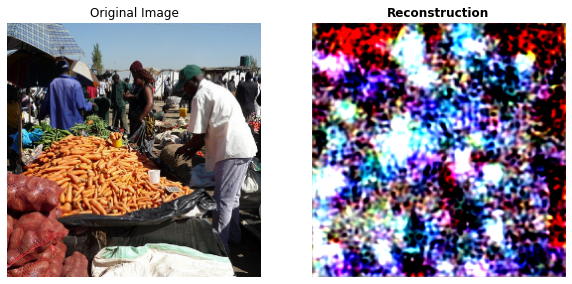

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 0/120 [02:46<?, ?it/s, train/bwd_pct_correct=tensor(0.0047, device='cuda:0'), train/cosine_sim_base=0.000108, train/fwd_pct_correct=tensor(0.0025, device='cuda:0'), train/loss=1.01e+3, train/lr=0.000507, train/mse_losses=5.05e+3, train/num_steps=29, train/temp=0.0094

umap plotting...


NameError: name 'clip_target_clsnorm' is not defined

In [11]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
for epoch in progress_bar:
    voxel2clip.train()

    sims_base = 0.
    val_sims_base = 0.
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    val_fwd_percent_correct = 0.
    val_bwd_percent_correct = 0.

    for train_i, (voxel, image, coco) in enumerate(train_dl):
        optimizer.zero_grad()
        
        repeat_index = train_i % 3

        image = image.float()
        voxel = voxel.float()[:,repeat_index].float()
        
        if voxel_dims == 3:
            voxel = voxel[:,np.unique(x_inc),:,:]
            voxel = voxel[:,:,np.unique(y_inc),:]
            voxel = voxel[:,:,:,np.unique(z_inc)]

        if epoch < int(mixup_pct * num_epochs):
            voxel, perm, betas, select = utils.mixco(voxel)

        if modality=='text':
            prompt = utils.select_annotations(annots[coco.cpu().numpy()], random=True).tolist()
            text_inputs = tokenizer(
                        prompt,
                        padding="max_length",
                        max_length=tokenizer.model_max_length,
                        truncation=True,
                        return_tensors="pt",
                    )
            text_input_ids = text_inputs.input_ids
            if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None
            prompt_embeds = text_encoder(
                text_input_ids.to(device),
                attention_mask=attention_mask,
            )
            embeds = text_encoder.text_projection(prompt_embeds.last_hidden_state)
            embeds_pooled = prompt_embeds.text_embeds
            clip_target = embeds / torch.norm(embeds_pooled.unsqueeze(1), dim=-1, keepdim=True)
        else:
            clip_target = clip_extractor.embed_image(image).float()
            clip_target = clip_target / torch.norm(clip_target[:, 0], dim=-1).reshape(-1, 1, 1)
            
        if not versatile and modality=='image':
            clip_target = clip_target[:,:1]
        clip_target = clip_target.view(len(clip_target),-1).to(voxel.dtype)
        
        clip_voxels = voxel2clip(voxel)
        
        clip_voxels_norm = nn.functional.normalize(clip_voxels, dim=-1)
        clip_target_norm = nn.functional.normalize(clip_target, dim=-1)
        
        if epoch < int(mixup_pct * num_epochs):
            loss = utils.mixco_nce(
                clip_voxels_norm,
                clip_target_norm,
                temp=voxel2clip.temp, perm=perm, betas=betas, select=select,
                distributed=distributed, accelerator=accelerator, local_rank=local_rank)
        else:
            loss = utils.soft_clip_loss(
                clip_voxels_norm,
                clip_target_norm,
                temp=voxel2clip.temp,
                distributed=distributed, accelerator=accelerator)
        
        if epoch < int(mixup_pct * num_epochs):
            mseloss = mse(clip_voxels[~select], clip_target[~select])
        else:
            mseloss = mse(clip_voxels, clip_target)
        mseloss *= 3000
        
        if with_mse:
            loss = (loss*(1-mse_amount)) + (mseloss * mse_amount)
        mse_losses.append(mseloss.item())
        utils.check_loss(loss)
        
        losses.append(loss.item())
        lrs.append(optimizer.param_groups[0]['lr'])
        
        # gather batches across multi-gpu if there's multiple
        clip_voxel_gather = accelerator.gather(clip_voxels_norm.contiguous())
        clip_target_gather = accelerator.gather(clip_target_norm.contiguous())
        
        sims_base += F.cosine_similarity(clip_target_gather,clip_voxel_gather).mean().item()
        
        # forward and backward top 1 accuracy        
        labels = torch.arange(len(clip_target_gather)).to(device) 
        fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxel_gather,clip_target_gather), labels, k=1)
        bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_gather, clip_voxel_gather), labels, k=1)

        accelerator.backward(loss)
        optimizer.step()

        if lr_scheduler_type is not None:
            lr_scheduler.step()

    voxel2clip.eval()
    for val_i, (voxel, image, coco) in enumerate(val_dl): 
        with torch.no_grad():
            # repeat_index = val_i % 3

            image = image.float()
            # voxel = voxel[:,repeat_index].float()
            voxel = torch.mean(voxel,axis=1).float().to(device)

            if voxel_dims == 3:
                voxel = voxel[:,np.unique(x_inc),:,:]
                voxel = voxel[:,:,np.unique(y_inc),:]
                voxel = voxel[:,:,:,np.unique(z_inc)]

            if val_image0 is None:
                val_image0 = image.detach().clone()
                val_voxel0 = voxel.detach().clone()

            if modality=='text':
                prompt = utils.select_annotations(annots[coco.cpu().numpy()], random=True).tolist()
                text_inputs = tokenizer(
                            prompt,
                            padding="max_length",
                            max_length=tokenizer.model_max_length,
                            truncation=True,
                            return_tensors="pt",
                        )
                text_input_ids = text_inputs.input_ids
                if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
                    attention_mask = text_inputs.attention_mask.to(device)
                else:
                    attention_mask = None
                prompt_embeds = text_encoder(
                    text_input_ids.to(device),
                    attention_mask=attention_mask,
                )
                embeds = text_encoder.text_projection(prompt_embeds.last_hidden_state)
                embeds_pooled = prompt_embeds.text_embeds
                clip_target = embeds / torch.norm(embeds_pooled.unsqueeze(1), dim=-1, keepdim=True)
            else:
                clip_target = clip_extractor.embed_image(image).float()
                clip_target = clip_target / torch.norm(clip_target[:, 0], dim=-1).reshape(-1, 1, 1)

            if not versatile and modality=='image':
                clip_target = clip_target[:,:1]
            clip_target = clip_target.view(len(clip_target),-1).to(voxel.dtype)
            
            clip_voxels = voxel2clip(voxel)

            clip_voxels_norm = nn.functional.normalize(clip_voxels, dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target, dim=-1)

            if epoch < int(mixup_pct * num_epochs):
                val_loss = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=voxel2clip.temp, perm=perm, betas=betas, select=select,
                    distributed=distributed, accelerator=accelerator, local_rank=local_rank)
            else:
                val_loss = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=voxel2clip.temp,
                    distributed=distributed, accelerator=accelerator)

            if epoch < int(mixup_pct * num_epochs):
                val_mseloss = mse(clip_voxels[~select], clip_target[~select])
            else:
                val_mseloss = mse(clip_voxels,clip_target)
            val_mseloss *= 3000
            if with_mse:
                val_loss = (val_loss*(1-mse_amount)) + (val_mseloss * mse_amount)
            val_mse_losses.append(val_mseloss.item())
            utils.check_loss(val_loss)

            val_losses.append(val_loss.item())
            
            clip_voxel_gather = accelerator.gather(clip_voxels_norm.contiguous())
            clip_target_gather = accelerator.gather(clip_target_norm.contiguous())

            val_sims_base += F.cosine_similarity(clip_target_gather,clip_voxel_gather).mean().item()

            labels = torch.arange(len(clip_target)).to(device)
            val_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxel_gather,clip_target_gather), labels, k=1)
            val_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_gather, clip_voxel_gather), labels, k=1)

    if local_rank==0:        
        if (not save_at_end and ckpt_saving) or (save_at_end and epoch == num_epochs - 1):
            # save best model
            val_loss = np.mean(val_losses[-(val_i+1):])
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_ckpt('best')
            else:
                print(f'not best - val_loss: {val_loss:.3f}, best_val_loss: {best_val_loss:.3f}')
                
        if utils.is_interactive():
            clear_output(wait=True)
            
        logs = {"train/loss": np.mean(losses[-(train_i+1):]),
            "val/loss": np.mean(val_losses[-(val_i+1):]),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "val/num_steps": len(val_losses),
            "train/cosine_sim_base": sims_base / (train_i + 1),
            "val/cosine_sim_base": val_sims_base / (val_i + 1),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "val/val_fwd_pct_correct": val_fwd_percent_correct / (val_i + 1),
            "val/val_bwd_pct_correct": val_bwd_percent_correct / (val_i + 1),
            "train/mse_losses": np.mean(mse_losses[-(train_i+1):]),
            "val/mse_losses": np.mean(val_mse_losses[-(val_i+1):]),
            "train/temp": voxel2clip.temp.item()}
        progress_bar.set_postfix(**logs)

        # Save model checkpoint and reconstruct
        save_ckpt(f'last')
        if epoch % ckpt_interval == 0:
            save_ckpt(f'last_backup')
            if n_samples_save > 0:
                print('reconstructing...')
                with torch.no_grad():
                    grid, _, _, _, _ = utils.reconstruct_from_clip(
                        val_image0, val_voxel0,
                        clip_extractor, unet, vae, noise_scheduler,
                        voxel2clip_img = voxel2clip, 
                        diffusion_priors = None,
                        text_token = None,
                        img_lowlevel = None,
                        num_inference_steps = num_inference_steps,
                        n_samples_save = n_samples_save,
                        recons_per_clip = 0,
                        recons_per_brain = 1,
                        guidance_scale = 7.5,
                        img2img_strength = 1, # 0=fully rely on img_lowlevel, 1=not doing img2img
                        timesteps = 1000,
                        seed = seed,
                        retrieve = False,
                        plotting = True,
                    )
                # grid.savefig(os.path.join(outdir, f'samples-val-epoch{epoch:03d}.png'))
                if wandb_log:
                    logs[f"val/recons"] = wandb.Image(grid, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()
                print('umap plotting...')
                combined = np.concatenate((clip_target_norm.flatten(1).detach().cpu().numpy(),
                                           clip_voxels_norm.flatten(1).detach().cpu().numpy()),axis=0)
                reducer = umap.UMAP(random_state=42)
                embedding = reducer.fit_transform(combined)

                colors=np.array([[0,0,1,.5] for i in range(len(clip_target_norm))])
                colors=np.concatenate((colors, np.array([[0,1,0,.5] for i in range(len(clip_voxels_norm))])))

                fig = plt.figure(figsize=(5,5))
                plt.scatter(
                    embedding[:, 0],
                    embedding[:, 1],
                    c=colors)
                # plt.savefig(os.path.join(outdir, f'umap-val-epoch{epoch:03d}.png'))
                if wandb_log:
                    logs[f"val/umap"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()
        if wandb_log: # save last ckpt so you can resume from it if need be
            wandb.save(os.path.abspath(outdir)+'/last.pth', base_path=os.path.abspath(outdir))
            if epoch % ckpt_interval == 0:
                wandb.save(os.path.abspath(outdir)+'/last_backup.pth', base_path=os.path.abspath(outdir))

        if wandb_log:
            wandb.log(logs)
            
    if distributed:
        dist.barrier()

if wandb_log and local_rank==0:
    wandb.finish()

print("\n===Finished!===\n")

In [ ]:
# mse(clip_voxels_clsnorm[~select].view(154,-1,768), clip_target_clsnorm[~select].view(154,-1,768))

In [ ]:
# mse(clip_voxels[~select], clip_target[~select])
#             # mseloss = mse(clip_voxels_clsnorm[~select], clip_target_clsnorm[~select])

In [ ]:
# train mse 2.14
# val mse 1.12